# Visualising Score & Schedules of the Diffusion Model


In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "jax"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

import numpy as np
import matplotlib.pyplot as plt
import timeit

import keras
import bayesflow as bf
from tqdm import tqdm

INFO:bayesflow:Using backend 'jax'


## Simulator<a class="anchor" id="simulator"></a>

In [2]:
def theta_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta):
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    r = np.random.normal(0.1, 0.01)
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

In [3]:
simulator = bf.make_simulator([theta_prior, forward_model])

In [4]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .rename("theta", "inference_variables")
    .rename("x", "inference_conditions")
)

# Training

In [5]:
num_training_batches = 512
num_validation_sets = 300
batch_size = 64
epochs = 50

In [6]:
training_data = simulator.sample(num_training_batches * batch_size)
validation_data = simulator.sample(num_validation_sets)

In [7]:
workflows = {}

for noise_schedule in ['cosine', 'edm']:
    diffusion_model_workflow = bf.BasicWorkflow(
        simulator=simulator,
        adapter=adapter,
        inference_network = bf.networks.DiffusionModel(
            noise_schedule=noise_schedule,
            prediction_type='velocity' if noise_schedule == 'cosine' else 'F',
        ),
    )
    workflows['diffusion_model_'+noise_schedule] = diffusion_model_workflow

for ot in [False, True]:
    flow_matching_workflow = bf.BasicWorkflow(
        simulator=simulator,
        adapter=adapter,
        inference_network = bf.networks.FlowMatching(
            use_optimal_transport=ot
        ),
    )
    workflows["flow_matching_ot" if ot else "flow_matching"] = flow_matching_workflow

In [13]:
for name, workflow in workflows.items():
    if os.path.exists('keras_'+name+'.keras'):
        print(f"Loading {name} from disk")
        workflow.fit_offline(  # otherwise some building steps are not executed
            training_data,
            epochs=1,
            batch_size=batch_size,
            validation_data=validation_data,
            verbose=0
        )
        workflow.approximator = keras.saving.load_model('keras_'+name+'.keras')
        continue

    print(f"Training {name}...")
    start = timeit.default_timer()
    workflow.fit_offline(
        training_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=0
    )
    workflow.approximator.save('keras_'+name+'.keras')
    end = timeit.default_timer()
    print(f"Trained {name} in {end - start:.2f} seconds")

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Loading diffusion_model_cosine from disk


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Loading diffusion_model_edm from disk


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Loading flow_matching from disk


INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Loading flow_matching_ot from disk


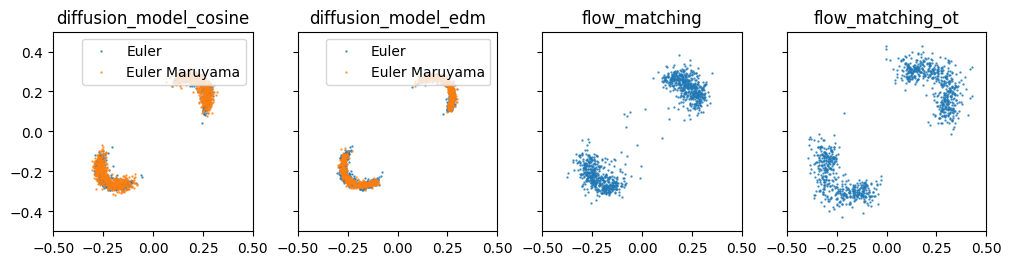

In [14]:
fig, ax = plt.subplots(ncols=len(workflows), figsize=(10, 5), layout='constrained', sharey=True, sharex=True)
for i, (name, workflow) in enumerate(workflows.items()):
    samples = workflow.sample(num_samples=1000, method="euler",
                              conditions={"x":np.array([[0.0, 0.0]], dtype=np.float32)})
    ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.5, label="Euler")

    if name.split('_')[0] == 'diffusion':
        samples = workflow.sample(num_samples=1000, method="euler_maruyama",
                                  conditions={"x":np.array([[0.0, 0.0]], dtype=np.float32)})
        ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.5, label="Euler Maruyama")
        ax[i].legend(loc="upper right")

    ax[i].set_title(name)
    ax[i].set_aspect('equal')
ax[-1].set_xlim([-0.5, 0.5])
ax[-1].set_ylim([-0.5, 0.5])
plt.show()

# Visualizing the Trajectory

In [23]:
def euler_backward_like(workflow, conditions, x0=None, steps=100, stochastic_solver=False):
    num_samples = 1  # not sure if the code would work with more, but not needed
    # conditions must always have shape (batch_size, ..., dims)
    conditions_prep = workflow.approximator._prepare_data(conditions)['inference_conditions']
    batch_size = keras.ops.shape(conditions_prep)[0]
    inference_conditions = keras.ops.expand_dims(conditions_prep, axis=1)
    inference_conditions = keras.ops.broadcast_to(
                    inference_conditions, (batch_size, num_samples, *keras.ops.shape(inference_conditions)[2:])
    )

    if workflow.approximator.inference_network.name.split('_')[0] == 'flow':
        t_start, t_end = 0.0, 1.0
    elif workflow.approximator.inference_network.name.split('_')[0] == 'diffusion':
        t_start, t_end = 1.0, 0.0
    else:
        raise ValueError("Unknown inference network type")

    dt = (t_end - t_start) / steps  # negative if integrating toward 0
    if x0 is not None:
        x = x0
    else:
        # sample from the base distribution
        x = workflow.approximator.inference_network.base_distribution.sample((1, num_samples))
    t = float(t_start)

    traj = []
    vels = []
    for k in range(steps):
        traj.append(keras.ops.convert_to_numpy(x))
        if workflow.inference_network.name.split('_')[0] != 'diffusion':
            v_curr = workflow.approximator.inference_network.velocity(
                xz=x, time=t, conditions=inference_conditions, training=False
            )
        else:
            # for diffusion models, we can use a stochastic solver
            v_curr = workflow.approximator.inference_network.velocity(
                xz=x, time=t, conditions=inference_conditions, stochastic_solver=stochastic_solver, training=False
            )
            if stochastic_solver:
                diff_curr = workflow.approximator.inference_network.diffusion_term(
                    xz=x, time=t, training=False
                )
                noise = keras.random.normal(keras.ops.shape(x), dtype=keras.ops.dtype(x)) * np.sqrt(np.abs(dt))
                x = x + diff_curr * noise

        x = x + dt * v_curr
        t = t + dt
        vels.append(keras.ops.convert_to_numpy(v_curr))

    traj = np.stack(traj, axis=0)      # shape [steps+1, batch, num_samples, dims]
    vels = np.stack(vels, axis=0)      # shape [steps,   batch, num_samples, dims]
    times = np.linspace(t_start, t_end, steps+1, dtype=np.float32)

    traj =  workflow.approximator.standardize_layers["inference_variables"](traj, forward=False)
    return traj, vels, times

In [24]:
x0 = workflows['diffusion_model_edm'].approximator.inference_network.base_distribution.sample((1, 1)) * 0
conditions = {"x":np.array([[0.0, 0.0]], dtype=np.float32)}

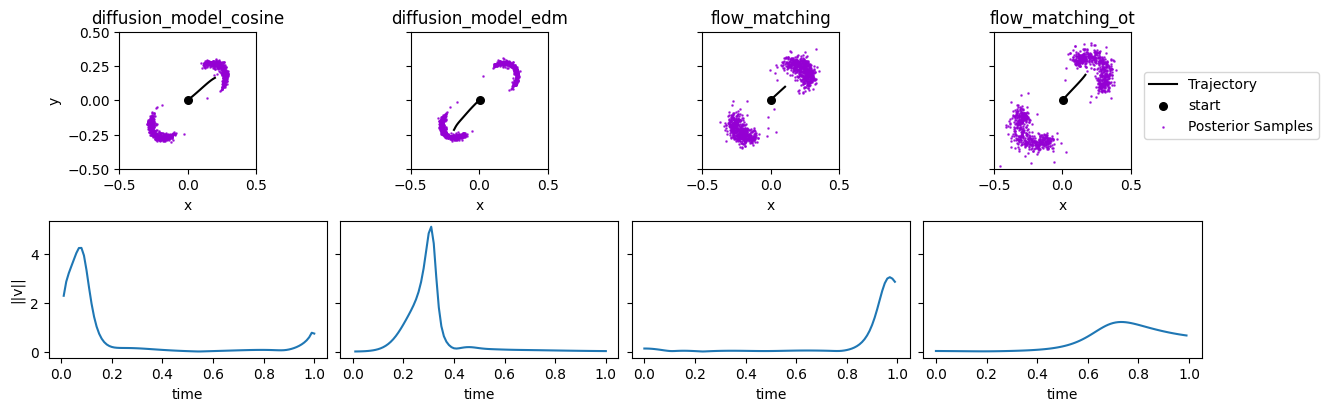

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=len(workflows), figsize=(3*len(workflows), 4),
                       layout='constrained', sharey='row', sharex='row')
for i, (name, workflow) in enumerate(workflows.items()):
    traj, vels, times = euler_backward_like(
        workflow, x0=x0, conditions=conditions, steps=100, stochastic_solver=False
    )
    traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
    vel_norm = np.linalg.norm(vels, axis=-1)
    ax[0, i].plot(traj[:, 0], traj[:, 1], color='black', label="Trajectory" if i == 0 else None)
    ax[0, i].scatter(traj[0, 0], traj[0, 1], s=30, marker='o', label='start' if i == 0 else None, color='black') # start
    #ax[0, i].scatter(traj[-1, 0], traj[-1, 1], s=30, marker='x', label='end' if i == 0 else None, color='black') # end

    samples = workflow.sample(num_samples=1000, conditions=conditions, method="euler")
    ax[0, i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.75,
                     color='darkviolet', label="Posterior Samples" if i == 0 else None)

    ax[1, i].plot(times[:-1], vel_norm)
    #ax[1, i].set_title("Velocity norm over time")
    ax[1, i].set_xlabel("time")

    ax[0, i].set_title(name)
    ax[0, i].set_aspect('equal')
    ax[0, i].set_xlabel("x")
fig.legend(bbox_to_anchor=(1.1, 0.85))
ax[0, 0].set_ylabel("y")
ax[0, -1].set_xlim([-0.5, 0.5])
ax[0, -1].set_ylim([-0.5, 0.5])
ax[1, 0].set_ylabel("||v||")
plt.show()

In [26]:
def moving_average(x, w=10):
    return np.convolve(x, np.ones(w)/w, mode="valid")

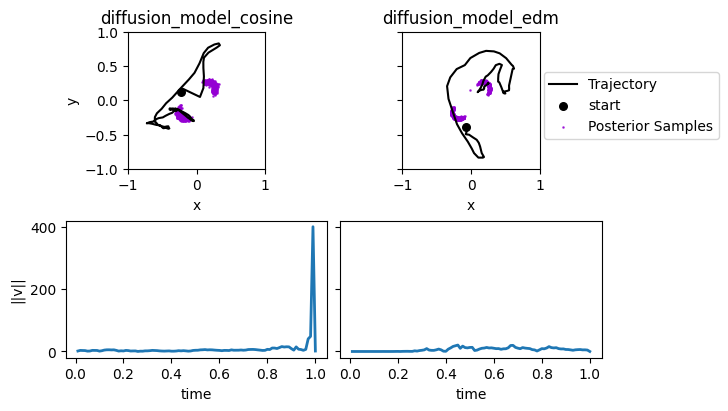

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(3*2, 4), layout='constrained', sharey='row', sharex='row')
for i, (name, workflow) in enumerate(workflows.items()):
    if name.split('_')[0] != 'diffusion':
        continue  # no stochastic solver

    traj, vels, times = euler_backward_like(
        workflow, x0=x0, conditions=conditions, steps=100, stochastic_solver=True
    )
    traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
    vel_norm = np.linalg.norm(vels, axis=-1)
    x_smooth = moving_average(traj[:,0])
    y_smooth = moving_average(traj[:,1])
    ax[0, i].plot(x_smooth, y_smooth, color='black', label="Trajectory" if i == 0 else None)
    ax[0, i].scatter(x_smooth[0], y_smooth[0], s=30, marker='o', label='start' if i == 0 else None, color='black')
    #ax[0, i].scatter(x_smooth[-1], y_smooth[-1], s=30, marker='x', label='end' if i == 0 else None, color='black')

    samples = workflow.sample(num_samples=1000, conditions=conditions, method="euler_maruyama")
    ax[0, i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.75,
                     color='darkviolet', label="Posterior Samples" if i == 0 else None)

    ax[1, i].plot(times[:-1], vel_norm, linewidth=2)
    #ax[1, i].set_title("Velocity norm over time")
    ax[1, i].set_xlabel("time")

    ax[0, i].set_title(name)
    ax[0, i].set_aspect('equal')
    ax[0, i].set_xlabel("x")
fig.legend(bbox_to_anchor=(1.2, 0.85))
ax[0, 0].set_ylabel("y")
ax[0, -1].set_xlim([-1, 1])
ax[0, -1].set_ylim([-1, 1])
ax[1, 0].set_ylabel("||v||")
plt.show()

In [28]:
n_trajectories = 50

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


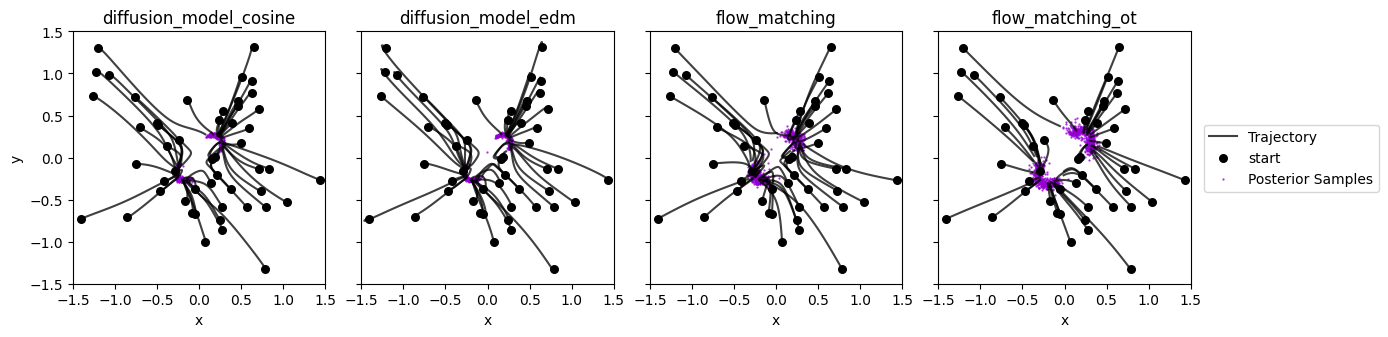

In [30]:
fig, ax = plt.subplots(ncols=len(workflows), figsize=(3*len(workflows), 4),
                       layout='constrained', sharey='row', sharex='row')
for j in tqdm(range(n_trajectories)):
    x0_i = workflows['diffusion_model_edm'].approximator.inference_network.base_distribution.sample((1, 1))
    for i, (name, workflow) in enumerate(workflows.items()):
        traj, vels, times = euler_backward_like(
            workflow, x0=x0_i, conditions=conditions, steps=100, stochastic_solver=False
        )
        traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
        ax[i].plot(traj[:, 0], traj[:, 1], color='black', alpha=0.75,
                   label="Trajectory" if i == 0 and j == 0 else None)
        ax[i].scatter(traj[0, 0], traj[0, 1], s=30, marker='o',
                      label='start' if i == 0 and j == 0 else None, color='black')
        #ax[i].scatter(traj[-1, 0], traj[-1, 1], s=30, marker='x',
        #              label='end' if i == 0 and j == 0 else None, color='black')

        if j == 0:
            samples = workflow.sample(num_samples=1000, conditions=conditions, method="euler")
            ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.4,
                          color='darkviolet', label="Posterior Samples" if i == 0 else None)

        ax[i].set_title(name)
        ax[i].set_aspect('equal')
        ax[i].set_xlabel("x")
fig.legend(bbox_to_anchor=(1.15, 0.6))
ax[0].set_ylabel("y")
ax[-1].set_xlim([-1.5, 1.5])
ax[-1].set_ylim([-1.5, 1.5])
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(3*2, 4),
                       layout='constrained', sharey='row', sharex='row')
for j in tqdm(range(int(n_trajectories*0.1))):
    x0_i = workflows['diffusion_model_edm'].approximator.inference_network.base_distribution.sample((1, 1))
    for i, (name, workflow) in enumerate(workflows.items()):
        if name.split('_')[0] != 'diffusion':
            continue  # no stochastic solver

        traj, vels, times = euler_backward_like(
            workflow, x0=x0_i, conditions=conditions, steps=100, stochastic_solver=True
        )
        traj, vels = traj[:, 0, 0], vels[:, 0, 0]  # take first batch item
        x_smooth = moving_average(traj[:,0])
        y_smooth = moving_average(traj[:,1])
        ax[i].plot(x_smooth, y_smooth, color='black', alpha=0.75,
                   label="Trajectory" if i == 0 and j == 0 else None)
        ax[i].scatter(x_smooth[0], y_smooth[0], s=30, marker='o',
                      label='start' if i == 0 and j == 0 else None, color='black')
        #ax[i].scatter(x_smooth[-1], y_smooth[-1], s=30, marker='x',
        #              label='end' if i == 0 and j == 0 else None, color='black')

        if j == 0:
            samples = workflow.sample(num_samples=1000, conditions=conditions, method="euler_maruyama")
            ax[i].scatter(samples["theta"][0, :, 0], samples["theta"][0, :, 1], alpha=0.75, s=0.4,
                          color='darkviolet', label="Posterior Samples" if i == 0 else None)

        ax[i].set_title(name)
        ax[i].set_aspect('equal')
        ax[i].set_xlabel("x")
fig.legend(bbox_to_anchor=(1.2, 0.6))
ax[0].set_ylabel("y")
ax[-1].set_xlim([-1.5, 1.5])
ax[-1].set_ylim([-1.5, 1.5])
plt.show()

In [ ]:
def velocity_field_plot(workflow, conditions, times, stochastic_solver=False,
                        traj=None, grid_limits=(-3,3), grid_points=20, name=None):
    # grid
    x = np.linspace(grid_limits[0], grid_limits[1], grid_points)
    y = np.linspace(grid_limits[0], grid_limits[1], grid_points)
    X, Y = np.meshgrid(x, y)
    grid = np.stack([X, Y], axis=-1)  # [grid_points, grid_points, 2]
    grid = grid.reshape(-1, 2)[None]  # [1, grid_points*grid_points, 2]

    grid_transf = workflow.approximator.standardize_layers["inference_variables"](grid.reshape(-1, 2), forward=False)
    grid_transf = keras.ops.convert_to_numpy(grid_transf)
    XY_transf = grid_transf.reshape(grid_points, grid_points, 2) # [G, G, 2]
    X_transf = XY_transf[..., 0]
    Y_transf = XY_transf[..., 1]

    # conditions must always have shape (batch_size, ..., dims)
    conditions_prep = workflow.approximator._prepare_data(conditions)['inference_conditions']
    batch_size = keras.ops.shape(conditions_prep)[0]
    inference_conditions = keras.ops.expand_dims(conditions_prep, axis=1)
    inference_conditions = keras.ops.broadcast_to(
                    inference_conditions, (batch_size, grid_points*grid_points, *keras.ops.shape(inference_conditions)[2:])
    )

    fig, axes = plt.subplots(1, len(times), figsize=(5*len(times), 5), layout='constrained',
                             sharex=True, sharey=True, squeeze=False)

    for i, t in enumerate(times):
        # expand to shape [batch, num_samples, dim]
        if workflow.inference_network.name.split('_')[0] != 'diffusion':
            v = workflow.inference_network.velocity(
                xz=grid, time=float(t), conditions=inference_conditions, training=False
            )
        else:
            # for diffusion models, we can use a stochastic solver
            v = workflow.inference_network.velocity(
                xz=grid, time=float(t), conditions=inference_conditions, stochastic_solver=stochastic_solver, training=False
            )
        v = keras.ops.convert_to_numpy(v)
        v = v[0, :, :2]  # [num_points, 2]

        U = v[:,0].reshape(grid_points, grid_points)
        V = v[:,1].reshape(grid_points, grid_points)

        ax = axes[0, i]
        ax.quiver(X_transf, Y_transf, U, -V, angles="xy", label="velocity field", alpha=0.5)
        if traj is not None:
            ax.plot(traj[:,0], traj[:,1], color="red", linewidth=2, label="trajectory")
            ax.scatter(traj[0,0], traj[0,1], color="green", s=60, label="start")
            ax.scatter(traj[-1,0], traj[-1,1], color="black", s=60, label="end")

        if name is not None:
            ax.set_title(f"{name} time={t:.2f}")
        else:
            ax.set_title(f"time={t:.2f}")
        ax.set_xlim((X_transf.min(), X_transf.max()))
        ax.set_ylim((Y_transf.min(), Y_transf.max()))
        ax.legend()
    plt.show()

In [ ]:
plot_times = [1.0, 0.5, 0.0]
for name, workflow in workflows.items():
    velocity_field_plot(
        workflow,
        conditions=conditions,
        times=plot_times if name.split('_')[0] == 'diffusion' else plot_times[::-1],
        stochastic_solver=False,
        name=name
    )

# Visualizing the Schedules

In [31]:
from bayesflow.networks.diffusion_model.schedules import EDMNoiseSchedule, CosineNoiseSchedule, NoiseSchedule

In [32]:
class FlowMatching(NoiseSchedule):
    def __init__(self):
        super().__init__(name="Flow Matching Schedule", variance_type="preserving", weighting=None)

    def get_log_snr(self, t, training):
        """Get the log signal-to-noise ratio (lambda) for a given diffusion time."""
        return 2 * keras.ops.log((1-t)/t)

    def get_t_from_log_snr(self, log_snr_t, training: bool):
        raise NotImplementedError

    def derivative_log_snr(self, log_snr_t, training):
        raise NotImplementedError

    def get_weights_for_snr(self, log_snr_t):
        return 1 + keras.ops.exp(-log_snr_t) + 2*keras.ops.exp(-log_snr_t / 2)

In [33]:
edm = EDMNoiseSchedule()
cosine = CosineNoiseSchedule()
edm.name = "EDM Schedule"
cosine.name = "Cosine Schedule"
fm = FlowMatching()

time = keras.ops.linspace(0.0, 1.0, 10000)
colors = ["blue", "orange", "green"]
schedules = [edm, cosine, fm]

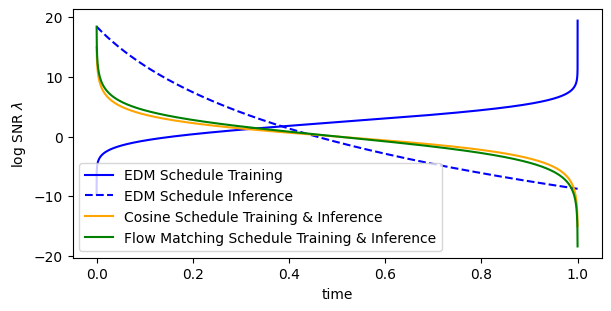

In [34]:
plt.figure(figsize=(6,3), layout='constrained')
for i, schedule in enumerate(schedules):
    training_schedule = keras.ops.convert_to_numpy(schedule.get_log_snr(time, training=True))
    inference_schedule = keras.ops.convert_to_numpy(schedule.get_log_snr(time, training=False))

    if (training_schedule != inference_schedule).all():
        plt.plot(time, training_schedule, label=f"{schedule.name} Training", color=colors[i])
        plt.plot(time, inference_schedule, label=f"{schedule.name} Inference", linestyle="--", color=colors[i])
    else:
        plt.plot(time, training_schedule, label=f"{schedule.name} Training & Inference", color=colors[i])
plt.legend()
plt.ylabel(r"log SNR $\lambda$")
plt.xlabel("time")
plt.show()

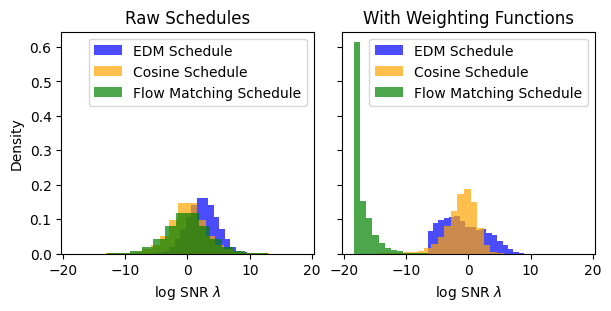

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(6,3), layout='constrained', sharey=True, sharex=True)
for i, schedule in enumerate(schedules):
    training_schedule = schedule.get_log_snr(time[1:-1], training=True)
    training_weights = keras.ops.convert_to_numpy(schedule.get_weights_for_snr(training_schedule))
    ax[0].hist(training_schedule, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)

    log_snr = np.random.choice(training_schedule, p=training_weights / training_weights.sum(), replace=True, size=10000)
    ax[1].hist(log_snr, density=True, color=colors[i], label=f"{schedule.name}", alpha=0.7, bins=20)

for a in ax:
    a.legend(loc="upper right")
    a.set_xlabel(r"log SNR $\lambda$")
ax[0].set_ylabel(r"Density")
ax[0].set_title("Raw Schedules")
ax[1].set_title("With Weighting Functions")
plt.show()

In [36]:
from scipy.stats import norm

sech = lambda x: 1 / np.cosh(x)

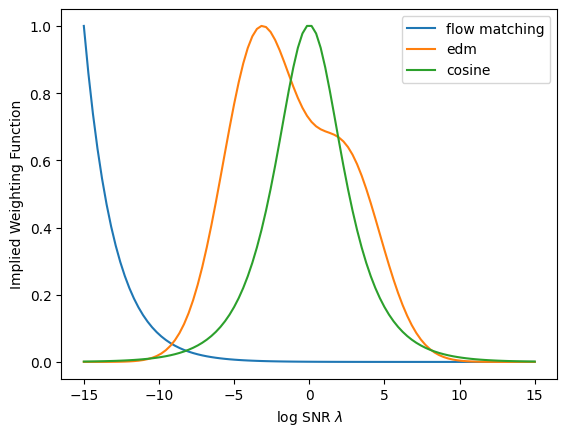

In [37]:
lambda_t = np.linspace(-15, 15, 100)
fm_w =  np.exp(-lambda_t/2)
edm_w = norm.pdf(lambda_t, loc=2.4, scale=2.4) * (np.exp(-lambda_t) + 1**2)
cosine_w = sech(lambda_t / 2)

plt.plot(lambda_t, fm_w / max(fm_w), label='flow matching')
plt.plot(lambda_t, edm_w / max(edm_w), label='edm')
plt.plot(lambda_t, cosine_w / max(cosine_w), label='cosine')
plt.xlabel(r"log SNR $\lambda$")
plt.ylabel("Implied Weighting Function")
plt.legend()
plt.show()